### E14 Project Shallow Focus

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

Duplicate key in file PosixPath('/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 401 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


#### 1. 모델 생성

In [47]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'
    
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()
        
        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')
            
        self.sess = tf.compat.v1.Session(graph=self.graph)
        
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
    
    def run(self, image):
        img_input = self.preprocess(image)
        
        
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME:[img_input]}
        )
        
        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map
        

In [37]:
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '~/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ~/aiffel/human_segmentation/models
model loaded successfully!


#### 2 인물 사진 
##### 2-1 이미지 불러오기  

In [144]:
img_path = os.getenv('HOME')+'/Aiffel/14_shallow_focus/images/suzy.jpg'  
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(512, 473, 3)


In [145]:
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(512, 473, 3) (513, 473, 3) 15


##### 2-2 사람 마스킹

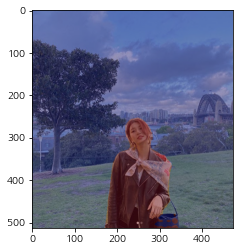

In [146]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

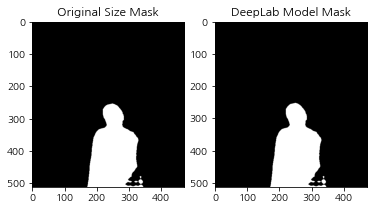

In [147]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1, 2, 1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

##### 2-3 배경 흐리게 하기 

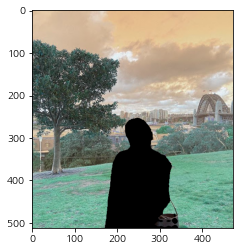

In [148]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

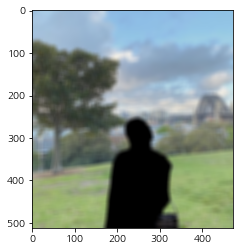

In [149]:
img_bg_blur = cv2.blur(img_bg, (13, 13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

##### 2-4 인물과 배경 사진 합치기 

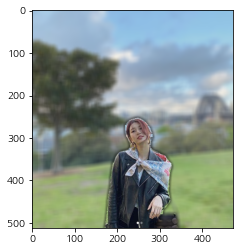

In [151]:
output_img_path = os.getenv('HOME')+'/Aiffel/14_shallow_focus/output/suzy_output.jpg'
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
cv2.imwrite(output_img_path, img_concat)
plt.show()

#### 3. 동물 사진 
##### 3-1 이미지 불러오기

In [152]:
img_path = os.getenv('HOME')+'/Aiffel/14_shallow_focus/images/cat.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(341, 512, 3)


In [153]:
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(341, 512, 3) (341, 513, 3) 8


##### 3-2 동물 마시킹

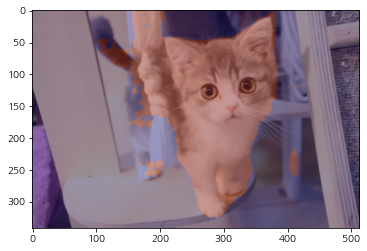

In [154]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

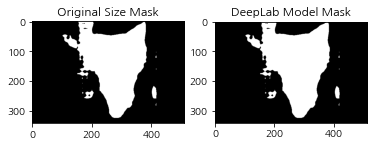

In [155]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1, 2, 1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

##### 3-3 배경 흐리게 하기

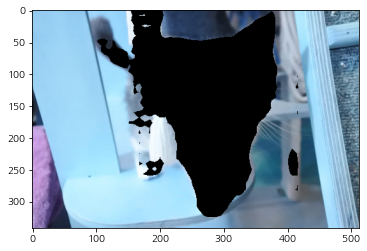

In [156]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

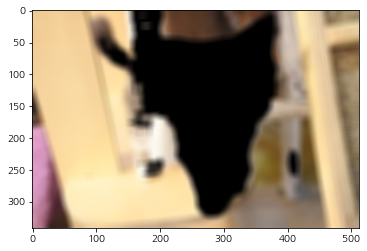

In [157]:
img_bg_blur = cv2.blur(img_bg, (13, 13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

##### 3-4 동물과 배경 사진 합치기

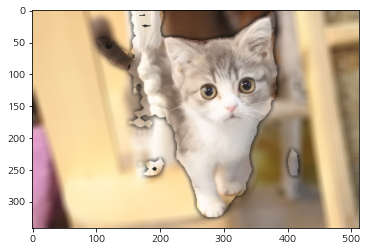

In [158]:
output_img_path = os.getenv('HOME')+'/Aiffel/14_shallow_focus/output/cat_output.jpg'
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
cv2.imwrite(output_img_path, img_concat)
plt.show()

#### 4. 배경 이미지 바꾸기
##### 4-1 이미지 불러오기 

In [159]:
img_path = os.getenv('HOME')+'/Aiffel/14_shallow_focus/images/IU.jpg'
bg_img_path = os.getenv('HOME')+'/Aiffel/14_shallow_focus/images/nightview.JPG'
img_orig = cv2.imread(img_path) 
bg_img_orig = cv2.imread(bg_img_path)
print (img_orig.shape)
print(bg_img_orig.shape)

(640, 640, 3)
(438, 780, 3)


In [160]:
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(640, 640, 3) (513, 513, 3) 15


##### 4-2 인물 마스킹

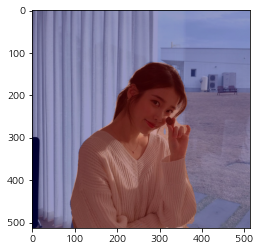

In [161]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

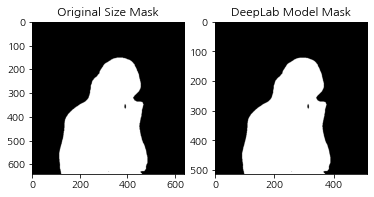

In [162]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1, 2, 1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)

plt.show()

##### 4-3 배경 이미지 크기 조절 

In [163]:
bg_resized_image = cv2.resize(bg_img_orig, (640, 640))

##### 4-4 인물과 배경 합치기 

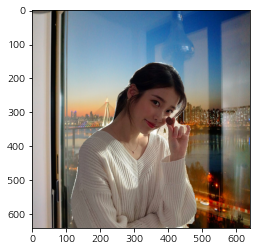

In [164]:
output_img_path = os.getenv('HOME')+'/Aiffel/14_shallow_focus/output/IU_output.jpg'
img_concat = np.where(img_mask_color==255, img_orig, bg_resized_image)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
cv2.imwrite(output_img_path, img_concat)
plt.show()

#### 5. 문제점

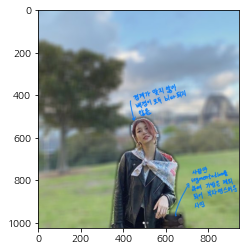

In [165]:
img_path = os.getenv('HOME')+'/Aiffel/14_shallow_focus/comment/suzy_output_comment.jpg' 
img_orig = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

- 경계가 정확하게 맞지 않아 배경이 모두 blur 되지 않는 문제 
- 사람만 masking 되어 같은 깊이에 있는 가방도 blur가 되는 문제

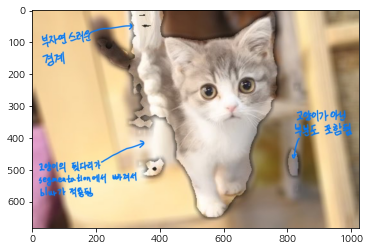

In [166]:
img_path = os.getenv('HOME')+'/Aiffel/14_shallow_focus/comment/cat_output_comment.jpg' 
img_orig = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

- 경계가 부정확 
- 고양이가 아닌 부분도 색상이 비슷하여 포함됨
- 고양이가 정확하게 masking 되지 않아 제대로 적용되지 않음

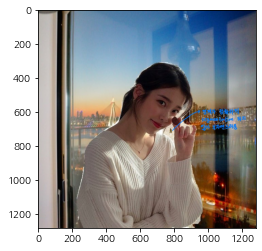

In [167]:
img_path = os.getenv('HOME')+'/Aiffel/14_shallow_focus/comment/IU_output_comment.jpg' 
img_orig = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

- 손과 몸사이도 masking되어 버리는 문제
- 경계가 정확하게 나누어 지지 않음 

**공통적인 문제점으로 경계가 정확하지가 않고 실제 카메라는 선명하게 나오는 부분과 같은 거리에 있는 것은 모두 선명하게 나오는데 반해 위의 사진들은 거리와 상관없이 masking이 된 물체만 선명하게 나오기 때문에 부자연스럽고 인위적인 느낌이 더 많이 나는 문제가 있음**

#### 6 해결 방안 
- ToF 센서 
    - ToF 센서를 활용하여 픽셀마다 거리 정보를 측정
    - 포커스의 거리와 같은 픽셀은 선명하게 이외의 픽셀을 흐려지게 적용
    - 위의 방법에서 더 자연스러운 사진을 위해 거리에 따라 비례적으로 blur를 적용하여 거리가 더 멀리 떨어져 있을수록 더 흐리게 만든다면 경계의 부자연스러움과 이미지의 인위적인 느낌이 많이 사라질것으로 생각됨 
    

#### 7 고찰 
- 아이폰 SE2로 인물사진을 촬영하여 확대를 하여보면 위의 문제처럼 경계가 정확하지 않은 사진이 만들어진 것을 본적이 있는데 이러한 사진을 만드는 방법과 또 이러한 문제가 생기는 이유를 알 수 있었다.
- 스마트폰의 사진에 많은 정보를 포함시켜가지고 있다면 촬영을 한 후에도 언제든지 사용자의 필요에 따라 보정을 할 수 있다는 것을 알 수 있었다. 